# Sparse State Lumping

Second-order dynamics on a physical network can be described by first-order dynamics on a second-order state network.

We can represent this second-order network by it's _state transition matrix_ $P_{ij}$ with the probabilities for the random walker to transition from state node $i$ to state node $j$.

In this view, we may note that some rows have similar probability distributions. We can measure how much information we lose when merging two state nodes with the [Jensen-Shannon Distance](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence).

The idea behind sparse state networks is that we can lump state nodes (within each physical node) that constrain the network flow in a similar way without losing (much) information.

In [47]:
from state_lumping_network import StateNetwork
import matplotlib.pyplot as plt
import numpy as np
from sklearn import cluster

## Generate state network of second order

In [48]:
pathNetwork = StateNetwork()
pathNetwork.generateStateNetworkFromPaths("output/CPE_Network_Pathways.net",
                                          "output/CPE_order_2.net",
                                          markovOrder=3, splitWeight=False,
                                          seed=3)

pathNetwork = StateNetwork()
pathNetwork.readFromFile("output/CPE_order_2.net")

Read path data from file 'output/CPE_Network_Pathways.net'...
Done, parsed 100/526 paths
 -> 0 return paths
Generated state network: StateNetwork (72 physical nodes, 310 state nodes and 217 links)
Writing state network to file 'output/CPE_order_2.net'...
Done!
Read state network from file 'output/CPE_order_2.net'...
 -> StateNetwork (72 physical nodes, 310 state nodes and 217 links)


##  Feature matrix

The feature matrix for a physical node is simply the rows of the state transition  matrix for the state nodes belonging to that physical node. To simplify, there is  a getFeatureMatrix method that removes all all-zero rows and columns in the feature matrix and provides a mapping back to the original state network. It takes the physical  node id as input parameter and returns a tuple (X, T), where X is the feature matrix  (np.array) of size (numNonDanglingStateNodes, numLinkedNodes) and T is a dictionary  transforming row index in the feature matrix to state node id.


In [49]:
X, rowToStateId = pathNetwork.getFeatureMatrix(101)
print("Feature matrix for the central physical node: \n{}\n rowToStateId: {}".format(X, rowToStateId))

Feature matrix for the central physical node: 
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
 rowToStateId: {0: 24, 1: 97, 2: 108, 3: 126, 4: 158, 5: 215}


##  Measure pairwise similarity

Now we can compare rows pairwise and cluster the most similar rows together. The Jensen-Shannon distance is unfortunately not implemented in scikit-learn (though it exist in a pull request), so let's create it.


In [50]:
import numpy as np
from sklearn.metrics import pairwise_distances

def plogp(x):
    x = np.asarray(x)
    return x * np.log2(x, where = x>0)

def entropy(x):
    return -np.sum(plogp(x))

def jensen_shannon_distance(x1, x2):
    x1 = np.asarray(x1)
    x2 = np.asarray(x2)
    mix = (x1 + x2) / 2
    return np.sqrt(entropy(mix) - (entropy(x1) + entropy(x2)) / 2)

def jensen_shannon_distances(X):
    return pairwise_distances(X, metric=jensen_shannon_distance)


##  Lump entire network

Now we can use general scikit-learn clustering algorithm that takes a custom pairwise distance function as a metric, like Agglomerative Clustering. We can also use for example cosine instead with similar results. 

Now we are ready to run this clustering code on the entire network. For convenience, StateNetwork provides a method clusterStateNodes that takes an argument clusterFeatureMatrix where you can send in a custom clustering function. This function gets a feature matrix as input argument and expects an array of cluster labels back.

In [51]:
def getFeatureClusterFunction(clusterRate=0.5):
    def calcClusters(X):
        numStates, numFeatures = X.shape
        if numStates < 2 or numFeatures < 2:
            # Don't cluster if too small
            return list(range(numStates))

        # Can be an adaptive number of clusters based on entropy reduction
        n_clusters = max(1, int(clusterRate * numStates))
        model = cluster.AgglomerativeClustering(
            linkage="complete",
            affinity=jensen_shannon_distances,
#             affinity="cosine",
            n_clusters=n_clusters
        )

        labels = model.fit_predict(X)
        return labels
    return calcClusters

pathNetwork.clusterStateNodes(clusterFeatureMatrix=getFeatureClusterFunction())



Cluster state nodes...
Generate lumped state network from clustering...
 -> 152 state nodes and 210 links in lumped network.


Did we lose any information?

The state network has two methods calcEntropyRate() and calcLumpedEntropyRate() to calculate the average number of bits required to encode the random walk on each physical node.


In [52]:

h1 = pathNetwork.calcEntropyRate()
h2 = pathNetwork.calcLumpedEntropyRate()
print("Entropy rate before: {}, after: {}".format(h1, h2))

from pathlib import Path
pathNetwork.writeLumpedStateNetwork("output/CPE_Network_order_3_lumped.net")
#print(Path('output/CPE_Network_lumped.net').read_text())


Entropy rate before: 0.021811410560382882, after: 1.2507877974806594
Writing lumped state network to file 'output/CPE_Network_order_3_lumped.net'...


## A Qeustion of Sparsity

A key question for the generation of sparse state networks is how sparse. If we lump all state nodes with each physical node, we lose all higher-order information and may underfit. On the other hand, keeping all second-order state nodes may overfit.

Here we will generate multiple lumped state networks with different amount of state nodes. A simple way is to parameterise this with a cluster rate $r$ going from 0.1 to 1, where `n_clusters = max(1, int(r * numStateNodes)`. For convenience, you can just send in the argument `clusterRate` to `clusterStateNodes` to achieve this, instead of the cluster function in the previous tutorial.

In [53]:
pathNetwork = StateNetwork()
pathNetwork.generateStateNetworkFromPaths("output/CPE_Network_Pathways.net",
                                          "output/CPE_states_training_order_3.net",
                                          outputValidationFilename="output/CPE_states_validation_order_3.net",
                                          markovOrder=3, splitWeight=True, validationProb=0.3,
                                          seed=3)

trainingNet = StateNetwork()
trainingNet.readFromFile("output/CPE_states_training_order_3.net")
validationNet = StateNetwork()
validationNet.readFromFile("output/CPE_states_validation_order_3.net")

Read path data from file 'output/CPE_Network_Pathways.net'...
Done, parsed 100/526 paths
 -> 0 return paths
Generated training state network: StateNetwork (66 physical nodes, 235 state nodes and 162 links)
Writing state network to file 'output/CPE_states_training_order_3.net'...
Generated validation state network: StateNetwork (47 physical nodes, 76 state nodes and 55 links)
Writing state network to file 'output/CPE_states_validation_order_3.net'...
Done!
Read state network from file 'output/CPE_states_training_order_3.net'...
 -> StateNetwork (66 physical nodes, 235 state nodes and 162 links)
Read state network from file 'output/CPE_states_validation_order_3.net'...
 -> StateNetwork (47 physical nodes, 76 state nodes and 55 links)


In [54]:
h0 = trainingNet.calcEntropyRate()
print("\nOriginal average entropy rate:", h0)
print("Original number of state nodes:", trainingNet.numStateNodes())


Original average entropy rate: 0.029171088970328028
Original number of state nodes: 235


In [55]:
clusterRates = np.linspace(0.1, 1, 20)
#clusterRates = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.98, 0.99, 0.999, 1.0]
trainNumStates = []
trainEntropyRate = []
valNumStates = []
valEntropyRate = []

for i, clusterRate in enumerate(clusterRates):
    trainingNet.clusterStateNodes(clusterRate=clusterRate)
    s = trainingNet.numLumpedStateNodes()
    h = trainingNet.calcLumpedEntropyRate()
    trainNumStates.append(s)
    trainEntropyRate.append(h)
    trainingNet.writeLumpedStateNetwork("output/states_training_lumped_{}.net".format(i))
    validationNet.clusterStateNodesFromNetwork(trainingNet)
    validationNet.writeLumpedStateNetwork("output/states_validation_lumped_{}.net".format(i))
    s = trainingNet.numLumpedStateNodes()
    h = trainingNet.calcLumpedEntropyRate()
    valNumStates.append(s)
    valEntropyRate.append(h)

Cluster state nodes...
Generate lumped state network from clustering...
 -> 98 state nodes and 150 links in lumped network.
Writing lumped state network to file 'output/states_training_lumped_0.net'...
Cluster state nodes from clustering in network StateNetwork (66 physical nodes, 235 state nodes and 162 links)...
Generate lumped state network from clustering...
 -> 70 state nodes and 55 links in lumped network.
Writing lumped state network to file 'output/states_validation_lumped_0.net'...
Cluster state nodes...
Generate lumped state network from clustering...
 -> 98 state nodes and 150 links in lumped network.
Writing lumped state network to file 'output/states_training_lumped_1.net'...
Cluster state nodes from clustering in network StateNetwork (66 physical nodes, 235 state nodes and 162 links)...
Generate lumped state network from clustering...
 -> 70 state nodes and 55 links in lumped network.
Writing lumped state network to file 'output/states_validation_lumped_1.net'...
Cluster 

Cluster state nodes...
Generate lumped state network from clustering...
 -> 164 state nodes and 159 links in lumped network.
Writing lumped state network to file 'output/states_training_lumped_17.net'...
Cluster state nodes from clustering in network StateNetwork (66 physical nodes, 235 state nodes and 162 links)...
Generate lumped state network from clustering...
 -> 70 state nodes and 55 links in lumped network.
Writing lumped state network to file 'output/states_validation_lumped_17.net'...
Cluster state nodes...
Generate lumped state network from clustering...
 -> 165 state nodes and 159 links in lumped network.
Writing lumped state network to file 'output/states_training_lumped_18.net'...
Cluster state nodes from clustering in network StateNetwork (66 physical nodes, 235 state nodes and 162 links)...
Generate lumped state network from clustering...
 -> 70 state nodes and 55 links in lumped network.
Writing lumped state network to file 'output/states_validation_lumped_18.net'...
Cl

How much information do we lose as we reduce the number of state nodes?

Note: Note that the original number of state nodes can be much larger than the maximum in the lumped state networks due to dangling nodes which are lumped implicitly.

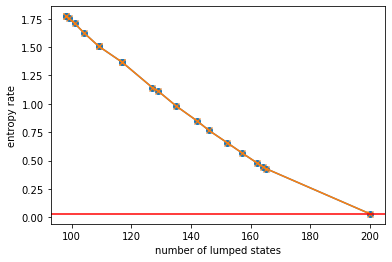

In [56]:
plt.plot(trainNumStates, trainEntropyRate, marker='o')
plt.plot(valNumStates, valEntropyRate, marker='x')
plt.xlabel("number of lumped states")
plt.ylabel("entropy rate")
plt.axhline(y=h0, color='r', linestyle='-')
#plt.axvline(x=trainingNet.numStateNodes(), color='r')
plt.show()    

Because compressing data is dual to finding regulartities in the data, minizming the modular description lenght of networks flows is dual to finding moudalr regualrities in the network flows.

### Validate with Infomap
The goal here is to calculate the codelength for the validation network, given the different partitions found on the lumped training networks.

**TODO:**

- Run Infomap on all lumped state networks and write a `.clu` file for each and store codelength
- Run Infomap on the validation network but with cluster data from external file for all `.clu` files generated from the lumped networks and store the codelength
- Plot the training and validation codelengths against the number of state nodes and check if there is an optimum that balances underfit and overfit

Note: Use the `--two-level` flag to Infomap here to find an optimum two-level solution that will be stored in the `.clu` files. These can be read into infomap with the `--cluster-data [clusters.clu]` option. Add `--no-infomap` to not continue the clustering algorithm after the initial clusters has been incorporated. Then the codelength after the run will be the codelength for the specified input clustering.

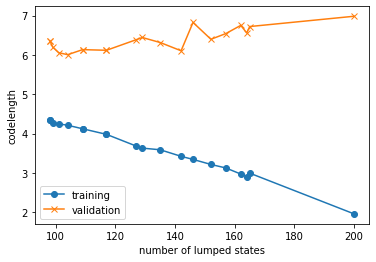

In [57]:
import infomap
trainingCodelengths = []
validationCodelengths = []

def calcCodelength(inputFilename, cluInputFile, flags="--directed --two-level"):
    im = infomap.Infomap("{} --no-infomap --input {} --cluster-data {}".format(flags, inputFilename, cluInputFile))
    im.run()
    return im.codelength

def partition(inputFilename, cluOutputFile=None, flags="--directed --two-level"):
    im = infomap.Infomap(flags)
    im.readInputData(inputFilename)
    im.run()
    if cluOutputFile:
        # Use second argument True to write the state-level clustering
        im.writeClu(cluOutputFile, True) # Second parameter shows States
    return im.codelength


for i, clusterRate in enumerate(clusterRates):
    trainingCodelength = partition("output/states_training_lumped_{}.net".format(i),
             "output/states_training_lumped_{}.clu".format(i))
    validationCodelength = calcCodelength("output/states_validation_lumped_{}.net".format(i),
             "output/states_training_lumped_{}.clu".format(i))
    trainingCodelengths.append(trainingCodelength)
    validationCodelengths.append(validationCodelength)
    #print("{}: training codelength: {} ({} nodes), validation codelength: {} ({} nodes)".format(i, trainingCodelength, trainNumStates[i], validationCodelength, valNumStates[i]))


plt.plot(trainNumStates, trainingCodelengths, marker='o')
plt.plot(valNumStates, validationCodelengths, marker='x')
plt.legend(["training", "validation"])
plt.xlabel("number of lumped states")
plt.ylabel("codelength")
#plt.ylim(ymin=4)
plt.show()

In [44]:
trainNumStates

[98, 101, 106, 114, 127, 135, 144, 157, 164, 200]

In [45]:
clusterRates 

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])